In [1]:
import os
import sys
import pandas as pd
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdchem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
import itertools
from itertools import combinations
from tqdm.notebook import tqdm
import random
from openbabel import pybel

from Rdkit_WLN_Ring_Scipt import show_atom_number

from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')

In [2]:
STDOUT = 1
STDERR = 2
class FDRedirector(object):
    def __init__(self, fd=STDOUT):
        self.fd = fd
        self.started = False
        self.piper = None
        self.pipew = None
    def start(self):
        if not self.started:
            self.oldhandle = os.dup(self.fd)
            self.piper, self.pipew = os.pipe()
            os.dup2(self.pipew, self.fd)
            os.close(self.pipew)

            self.started = True
    def flush(self):
        if self.fd == STDOUT:
            sys.stdout.flush()
        elif self.fd == STDERR:
            sys.stderr.flush()
    def stop(self):
        if self.started:
            self.flush()
            os.dup2(self.oldhandle, self.fd)
            os.close(self.oldhandle)
            f = os.fdopen(self.piper, 'r')
            output = f.read()
            f.close()

            self.started = False
            return output
        else:
            return ''
    def getvalue(self):
        output = self.stop()
        self.start()
        return output
redirect = FDRedirector(STDERR)

In [3]:
def check_wln_validity(wln):
    redirect.start();
    mymol = pybel.readstring("wln", wln)
    smi = mymol.write("smi")[:-2]
    
    captured_stderr = redirect.stop()
    if len(captured_stderr)==0:
        return wln, smi
    else:
        return wln, 'wrong'

### Custom Iterator for Compact Benzene Notion, Rest is using the normal iterator 

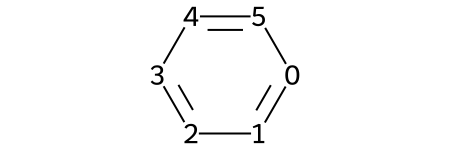

In [4]:
WLN = 'RH'
mymol = pybel.readstring("wln", WLN)
smi = mymol.write("smi")[:-2]
mol = Chem.MolFromSmiles(smi)
cleaned_smiles = Chem.MolToSmiles(mol)
Base_mol = Chem.MolFromSmiles(cleaned_smiles) # this clean step is essential
show, _ = show_atom_number(Base_mol, 'atomLabel')
show

In [5]:
WLN_positions = {'A':0,'B':1,'C':2,'D':3,'E':4, 'F':5}

print(f'Indexes 0 to {len(WLN_positions)-1} to chose from on the Ring')
print(f'Bonding group head at atomic position {len(WLN_positions)}')

atom_assignments = [i for i in range(len(WLN_positions))]

pos_combinations = sum([list(map(list, combinations(atom_assignments, i))) for i in range(len(atom_assignments) + 1)], [])
print(f'{len(pos_combinations)} Possible Combinations Found')
pos_combinations = pos_combinations[1:]

Indexes 0 to 5 to chose from on the Ring
Bonding group head at atomic position 6
64 Possible Combinations Found


In [6]:
# Small Fragments

def pruner(dataframe):
    columns = ['WLN', 'SMILES']
    for i in dataframe:
        if i not in columns:
            dataframe = dataframe.drop(columns=i)
    return dataframe

PATH = '/Users/michaelblakey/Documents/The_Frey_Group/WLN_Project/Code/AutoEncoder/core/data/'

Big_data = pd.read_csv(PATH +'full-reaugment_1.txt', delimiter='\t')

TYPE = 'Non-Carbon'
Fragments = Big_data[Big_data.Labels.str.contains(TYPE)==True]

Fragments = pruner(Fragments[:1000])
print(Fragments.head(3))
print(Fragments.tail(3))

       WLN  SMILES
135528   E   [Br-]
135529   Q   [OH-]
135531   Z  [NH2-]
          WLN        SMILES
159866  QPNG&      OP[N-]Cl
159867  GBNEP  Cl[B-]N(Br)P
159888  QPPZF       OPP(N)F


In [7]:
iterations = 10000

candidates = []
for comb in tqdm(pos_combinations):
    for i in range(iterations):
        wln_positions = [list(WLN_positions.keys())[list(WLN_positions.values()).index(i)] for i in comb]
        num_fragments = len(wln_positions)
        wln_frags = []
        for i in range(num_fragments):
            Random_Frag = Fragments.sample(1, random_state = None)
            wln_frag = Random_Frag['WLN'].item()
            wln_frags.append(wln_frag)
        build_list = []   
        for i in range(num_fragments):
            built = wln_positions[i] + wln_frags[i]
            build_list.append(built)
            
        new_wln = [WLN] + build_list
        compact = ' '.join(new_wln)
        candidates.append(compact)

SEND_WLN = []
SEND_SMI = []
for wln in tqdm(candidates):
    wln, smiles = check_wln_validity(wln)
    SEND_WLN.append(wln)
    SEND_SMI.append(smiles)
    
Working = pd.DataFrame()
Working['SMILES'] = SEND_SMI
Working['WLN'] = SEND_WLN

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/630000 [00:00<?, ?it/s]

In [9]:
Wrong = Working[Working['SMILES']=='wrong']
Correct = Working[Working['SMILES']!='wrong']


Correct = Correct.reset_index()
keys = []
for smi in tqdm(Correct['SMILES']):
    mymol = pybel.readstring("smi", smi)
    key = mymol.write("inchikey")[:-1]
    keys.append(key)
    
Correct['KEYS'] = keys
dup_index = []
for index, i in enumerate(Correct['KEYS'].duplicated()):
    if i ==True:
        dup_index.append(index)
        
Correct = Correct.drop(index = dup_index)
Correct = Correct.reset_index()
print(f"{len(Correct)} New WLN Ring Strings for Database")
print(f"{len(Wrong)} New Wrong Examples Stored for Classifier")

  0%|          | 0/153292 [00:00<?, ?it/s]

132909 New WLN Ring Strings for Database
476708 New Wrong Examples Stored for Classifier


In [52]:
from IPython.display import clear_output
from collections import OrderedDict

alphabets = 'abcdefghijklmnopqrstuvwxyz&'.upper()
indexes = [i for i in range(len(alphabets))]
positioning_dict = OrderedDict(zip(alphabets, indexes))


def letter_index(lettered_group, positioning_dict):
    index = positioning_dict[lettered_group[0]]
    return index


def reorder_groups(groups):
    letter_order = []
    for i in groups:
        index = positioning_dict[i[0]]
        letter_order.append(index)
    trial = list(zip(groups, letter_order))
    trial.sort(key=lambda tup: tup[1])
    reordered_groups = [i[0] for i in trial]

    return reordered_groups


def Simplify(group_list, positioning_dict, alphabets):
    groups = []
    indexes = []
    for i in group_list:
        index = letter_index(i, positioning_dict)
        indexes.append(index)
    anchor = indexes[0]

    new_indexes = [i - anchor for i in indexes]
    new_letters = [alphabets[i] for i in new_indexes]
    naked = [i[1:] for i in group_list]

    compact = [new_letters[i] + naked[i] for i in range(len(new_letters))]
    compact[0] = 'R' + compact[0][1:]
    compact = " ".join(compact)
    return compact

def Iterator(og):
    split_list = og.split(' ')
    reordered = reorder_groups(split_list[1:])

    if not reordered:
        new_wln = 'RH'
        return new_wln

    for a in range(len(reordered)):
        if len(reordered[a]) == 1:
            reordered[a] = reordered[a] + '1'

    if len(reordered) > 1:
        new_wln = Simplify(reordered, positioning_dict, alphabets)
        return new_wln

    else:
        new_wln = 'R' + reordered[0][1:]
        return new_wln

In [53]:
pybel.ob.obErrorLog.SetOutputLevel(0)

new_data = []
compacter = 0
for Index, row in Correct.iterrows():
    clear_output(wait=True)
    print(Index)
    before = row['WLN']
    wln = Iterator(before)
    
    testing = pybel.readstring("wln", wln) 
    original = pybel.readstring("wln", before) 
    
    a = testing.write("inchikey")
    b = original.write("inchikey")
    if a != b:
        split_list = before.split(' ')
        reordered = reorder_groups(split_list)
        compact = ['RH'] + split_list
        wln = " ".join(compact)
        
        testing = pybel.readstring("wln", wln) 
        original = pybel.readstring("wln", before ) 
        
        a = testing.write("inchikey")
        b = original.write("inchikey")
        if a == b:
            new_data.append(wln)
            compacter +=1
        if a != b:
            new_data.append(before)
    else:
        new_data.append(wln)  
        compacter +=1
        
Correct['COMPACTED'] = new_data
print(compacter)

132908
132115


In [54]:
folder = 'Generated_Data'
Working = Correct[['COMPACTED', 'SMILES']]
Working = Working.rename(columns={'COMPACTED':'WLN'})
Working.to_csv(folder+'/Single_Ring_CompactNotation_3.txt', sep='\t')

## Compact Rings on Rings Fragment Preperation

For attachment to another ring, we need full ring notation as created in Correct
RH causes errors 

All fragments must be ended with a string ender character '&'

In [ ]:
PATH = '/Users/michaelblakey/Documents/The_Frey_Group/WLN_Project/Code/AutoEncoder/core/data/'

Big_data = pd.read_csv(PATH +'full-reaugment_1.txt', delimiter='\t')

TYPE = ''
Fragments = Big_data[Big_data.Labels.str.contains(TYPE)==True]
Fragments = Fragments[Fragments.SMILES.str.contains(r'[.]')==False]

Fragments = pruner(Fragments[:1000])
print(Fragments.head(3))
print(Fragments.tail(3))

In [ ]:
fragments = []
for i in Fragments['WLN']:
    fragment = i + '&'
    fragments.append(fragment)
    
Fragments['Frags'] = fragments

In [ ]:
Fragments['Frags']

In [ ]:
WLN_positions = {'B':1,'C':2,'D':3,'E':4, 'F':5}

print(f'Indexes 0 to {len(WLN_positions)-1} to chose from on the Ring')
print(f'Bonding group head at atomic position {len(WLN_positions)}')

atom_assignments = [i+1 for i in range(len(WLN_positions))]

pos_combinations = sum([list(map(list, combinations(atom_assignments, i))) for i in range(len(atom_assignments) + 1)], [])
print(f'{len(pos_combinations)} Possible Combinations Found')
pos_combinations = pos_combinations[1:]

In [ ]:
iterations = 10000

candidates = []
for comb in tqdm(pos_combinations):
    for i in range(iterations):
        WLN = Fragments['Frags'].sample(1, random_state = None).item()
        wln_positions = [list(WLN_positions.keys())[list(WLN_positions.values()).index(i)] for i in comb]
        num_fragments = len(wln_positions)
        wln_frags = []
        for i in range(num_fragments):
            wln_frag = random.choice([Fragments['WLN'].sample(1, random_state = None).item(),
                                         Fragments['Frags'].sample(1, random_state = None).item()]) 
            wln_frags.append(wln_frag)
        build_list = []   
        for i in range(num_fragments):
            built = wln_positions[i] + wln_frags[i]
            build_list.append(built)
            
        new_wln = [WLN] + build_list
        compact = ' '.join(new_wln)
        candidates.append(compact)

SEND_WLN = []
SEND_SMI = []
print('Validity Checking...')
for wln in tqdm(candidates):
    wln, smiles = check_wln_validity(wln)
    SEND_WLN.append(wln)
    SEND_SMI.append(smiles)
    
Experimental = pd.DataFrame()
Experimental['SMILES'] = SEND_SMI
Experimental['WLN'] = SEND_WLN
Experimental

In [ ]:
pybel.ob.obErrorLog.SetOutputLevel(0)

Wrong = Experimental[Experimental['SMILES']=='wrong']
Correct = Experimental[Experimental['SMILES']!='wrong']
Correct = Correct.reset_index()
keys = []
for smi in tqdm(Correct['SMILES']):
    mymol = pybel.readstring("smi", smi)
    key = mymol.write("inchikey")[:-1]
    keys.append(key)
    
Correct['KEYS'] = keys
dup_index = []
for index, i in enumerate(Correct['KEYS'].duplicated()):
    if i ==True:
        dup_index.append(index)
        
Correct = Correct.drop(index = dup_index)
print(f"{len(Correct)} New WLN Ring Strings for Database")
print(f"{len(Wrong)} New Wrong Examples Stored for Classifier")

In [ ]:
folder = 'Generated_Data'
Working = Correct[['WLN','SMILES']]
Working.to_csv(folder+'/Stage2_Multi_Ring_CompactNotation_3.txt', sep='\t')